# SD-FEC LDPC Encoder/Decoder Loopback

### Download Overlay

In [1]:
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import numpy as np
import xsdfec

ol = Overlay('ldpc_loopback.bit')

## Encoder

### Inspect Available LDPC Codes

In [2]:
fec = ol.ldpc_encoder.sd_fec
ldpc_params = fec.available_ldpc_params()
ldpc_params

['docsis_short',
 'docsis_medium',
 'docsis_long',
 'docsis_init_ranging',
 'docsis_fine_ranging',
 'wifi802_11_cr1_2_648',
 'wifi802_11_cr1_2_1296',
 'wifi802_11_cr1_2_1944',
 'wifi802_11_cr2_3_648',
 'wifi802_11_cr2_3_1296',
 'wifi802_11_cr2_3_1944',
 'wifi802_11_cr3_4_648',
 'wifi802_11_cr3_4_1296',
 'wifi802_11_cr3_4_1944',
 'wifi802_11_cr5_6_648',
 'wifi802_11_cr5_6_1296',
 'wifi802_11_cr5_6_1944',
 '5g_graph1_set1_l5_p32',
 '5g_graph1_set1_l5_p64',
 '5g_graph1_set1_l5_p128',
 '5g_graph1_set1_l5_p256',
 '5g_graph1_set2_l5_p384',
 '5g_graph1_set1_l46_p32',
 '5g_graph1_set1_l46_p64',
 '5g_graph1_set1_l46_p128',
 '5g_graph1_set1_l46_p256',
 '5g_graph1_set2_l46_p384',
 '5g_graph2_set1_l7_p32',
 '5g_graph2_set1_l7_p64',
 '5g_graph2_set1_l7_p128',
 '5g_graph2_set1_l7_p256',
 '5g_graph2_set2_l7_p384',
 '5g_graph2_set1_l42_p32',
 '5g_graph2_set1_l42_p64',
 '5g_graph2_set1_l42_p128',
 '5g_graph2_set1_l42_p256',
 '5g_graph2_set2_l42_p384']

### Add LDPC Parameters to SD-FEC Internal Memory

In [3]:
fec.CORE_ORDER = 0                         # In order outputs
fec.CORE_AXIS_ENABLE = 0                   # Ensure FEC is disabled (000000)

sc_offset = 0
la_offset = 0
qc_offset = 0
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Status','Code ID','SC Offset','LA Offset','QC Offset','Code Name'))
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('------','------','------','------','------','------'))
for code_id in range(len(ldpc_params)):
    
    code_name = ldpc_params[code_id]
    sc_table = fec._code_params.ldpc[code_name]['sc_table']
    la_table = fec._code_params.ldpc[code_name]['la_table']
    qc_table = fec._code_params.ldpc[code_name]['qc_table']
    if type(sc_table) != list : sc_table = [sc_table]

    if (sc_offset + len(sc_table)) > len(fec.LDPC_SC_TABLE):
        print("\nNot enough space for SC table: %s. Terminating.\n" % (code_name))
        break
    if (la_offset*4 + len(la_table)) > len(fec.LDPC_LA_TABLE):
        print("\nNot enough space for LA table: %s. Terminating.\n" % (code_name))
        break
    if (qc_offset*4 + len(qc_table)) > len(fec.LDPC_QC_TABLE):
        print("\nNot enough space for QC table: %s. Terminating.\n" % (code_name))
        break
    
    print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Loaded',code_id, sc_offset, la_offset, qc_offset, code_name))
    fec.add_ldpc_params(code_id, sc_offset, la_offset, qc_offset, code_name)

    sc_offset += len(sc_table)
    la_offset += int(np.ceil(len(la_table)/4))
    qc_offset += int(np.ceil(len(qc_table)/4))
    
fec.CORE_AXIS_ENABLE = 63                  # Enable FEC (111111)

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short
Loaded     1          2          2          21         docsis_medium
Loaded     2          4          4          54         docsis_long
Loaded     3          6          6          97         docsis_init_ranging
Loaded     4          8          8          112        docsis_fine_ranging
Loaded     5          9          9          120        wifi802_11_cr1_2_648
Loaded     6          15         15         196        wifi802_11_cr1_2_1296
Loaded     7          21         21         240        wifi802_11_cr1_2_1944
Loaded     8          27         27         270        wifi802_11_cr2_3_648
Loaded     9          31         31         324        wifi802_11_cr2_3_1296
Loaded     10         35         35         360        wifi802_11_cr2_3_1944
Loaded     11         39         39         388       

### Select Code to Perform Encoding

In [4]:
code_name = 'docsis_short'
code_id = ldpc_params.index(code_name)

n = fec._code_params.ldpc[code_name]['n']
k = fec._code_params.ldpc[code_name]['k']
p = fec._code_params.ldpc[code_name]['p']

print('Block Length (bits): %s\nInformation Bits: %s\nSub-Matrix Size: %s' % (n, k, p))

Block Length (bits): 1120
Information Bits: 840
Sub-Matrix Size: 56


### Data Buffers

In [5]:
axis_width = 32 // 8
num_words = 1
pad = axis_width // num_words

K = int(np.ceil(k/8))
N = int(np.ceil(n/8))

tx_buffer = allocate(shape=(K*pad,), dtype=np.uint8)
rx_buffer = allocate(shape=(N*pad,), dtype=np.uint8)

for i in range(len(tx_buffer))[::pad]:
    tx_buffer[i] = np.random.randint(1,255)

### Control Buffer

In [6]:
def non_5G_ldpc_ctrl_enc(id, code):
    id = '{0:08b}'.format(id)
    reserved = '{0:017b}'.format(0)
    code = '{0:07b}'.format(code)
    
    print('Code ID: ', int(id,2))
    print('Code Name: ', int(code,2))
    
    ctrl = id + reserved + code
    
    return(int(ctrl,2))

ctrl_buffer = allocate(shape=(1,), dtype=np.uint32)

ctrl_buffer[0] = non_5G_ldpc_ctrl_enc(code_id, 0)

Code ID:  0
Code Name:  0


### Status Buffer

In [7]:
def non_5G_ldpc_status_enc(status):
    binary = '{0:032b}'.format(status)
    
    id = binary[0:8]
    hard_op = binary[17]
    op = binary[18]
    code = binary[24:32]

    print('Code ID: ', int(id,2))
    print('Hard Output: ', int(hard_op,2))
    print('Operation: ', int(op,2))
    print('Code Name: ', int(code,2))
    
status_buffer = allocate(shape=(1,), dtype=np.uint32)

### Transfer Data

In [8]:
dma_data = ol.ldpc_encoder.axi_dma_data
dma_ctrl = ol.ldpc_encoder.axi_dma_ctrl

dma_ctrl.sendchannel.transfer(ctrl_buffer)
dma_data.sendchannel.transfer(tx_buffer)
dma_ctrl.recvchannel.transfer(status_buffer)
dma_data.recvchannel.transfer(rx_buffer)

dma_ctrl.sendchannel.wait()
dma_data.sendchannel.wait()
dma_data.recvchannel.wait()
dma_ctrl.recvchannel.wait()

### Inspect Data

In [9]:
import pandas as pd
pd.set_option('display.max_rows', 10000)

print('\nStatus - ')
non_5G_ldpc_status_enc(status_buffer[0])

tx_frame = pd.DataFrame({'TX': tx_buffer[::pad]})
rx_frame = pd.DataFrame({'RX': rx_buffer[::pad]})

compare = pd.concat([tx_frame, rx_frame], axis=1)

if not (tx_buffer[0:(K-1)*pad] == rx_buffer[0:(K-1)*pad]).all():
    print('\nFalse: ', code_name, np.asarray(np.where(tx_buffer[0:(K-1)*pad] != rx_buffer[0:(K-1)*pad]))/pad)
else:
    print('\nTrue: ', code_name)


Status - 
Code ID:  0
Hard Output:  1
Operation:  1
Code Name:  0

True:  docsis_short


## Hard to Soft

### Serialise Data

In [10]:
hard_data = rx_buffer[::pad]

hard_binary = ''
for hd in hard_data:
    h_bin = '{0:08b}'.format(hd)
    hard_binary += h_bin[::-1] # Decoder accepts LSB first
    
print(hard_binary)

1010000101110100010110001100111000110011110110001010000000110011110111001011100000110101110110101111111010100000101001100010000100010001111001011000110101010111010110001000111001001100011001111101110101111000111000110001100111101000000110111010100001000010011011110011001010011110010101011110010001111100110111110110101110000111110110100001010111011101000110101011111100000001000011011000011100110010100100110110000101101000100010100110101000101010001010000000001101011001011101111001011100010000101110011001111101011100010111001001000110001001000011100110011111101000010111010010001000110001110101010001000010011110110001000110010100000100010010100110000010110000100011000111011000010011100101111100100010101011010110000110101100100011101110111011001010100111100101000100110110101011000010111111001111010011010001110011101000010010110010000101111110101001111100011001011111111010000100100101100110110000011111011011111111010110110101001100111100010011011101000010110011000101000101001011000000100010

### Modulate Data

<function matplotlib.pyplot.show(*args, **kw)>

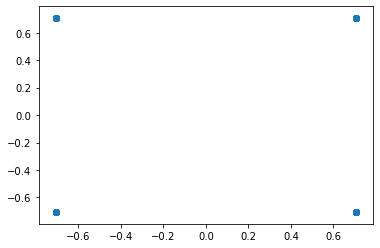

In [23]:
L = 2 # Symbol length

modulated = np.empty(0)
for i in range(0, len(hard_binary), L):
    symbol = hard_binary[i : i+L]
    
    if symbol == '00':
        mod = np.exp(3j*np.pi/4)
    elif symbol == '01':
        mod = np.exp(5j*np.pi/4)
    elif symbol == '11':
        mod = np.exp(7j*np.pi/4)
    elif symbol == '10':
        mod = np.exp(1j*np.pi/4)
        
    modulated = np.append(modulated, mod)
    
x = [n.real for n in modulated]
y = [n.imag for n in modulated]   

plt.scatter(x, y)
plt.show

### AWGN Channel

In [46]:
len(modulated)

560

<function matplotlib.pyplot.show(*args, **kw)>

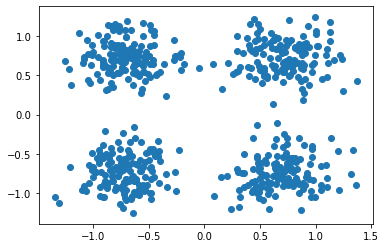

In [50]:
SNR = 10
signal_power = np.sum(np.square(np.absolute(modulated)))/len(modulated)
N = signal_power/SNR
noise_variance = N/2
sigma = np.sqrt(noise_variance)

noise = np.random.normal(0, sigma, len(modulated)*2).view(np.complex128)

noise_modulated = noise + modulated

x = [n.real for n in noise_modulated]
y = [n.imag for n in noise_modulated]   

plt.scatter(x, y)
plt.show

### Soft-Demodulate Data

In [ ]:
# Need to work this bit out!!!

### Format LLR Values

In [37]:
def format_llr(v):
    # Perform symmetric saturation
    if v > 7.75:
        v = 7.75
    elif v < -7.75:
        v = -7.75

    v = int(v * pow(2,2)) # Bit shift to expose 2 fractional

    # Convert to binary (2's complement)
    if v >= 0:
        b = '{0:06b}'.format(v)
    else:
        b = '{0:06b}'.format(pow(2,6)+v)

    # Sign extend to 8-bits
    if b[0] == '0': # Number is positive
        b_ex = '00' + b
    else: # Number is negative
        b_ex = '11' + b

    return int(b_ex,2)

## Decoder

### Add LDPC Parameters to SD-FEC Internal Memory

In [ ]:
fec = ol.ldpc_decoder.sd_fec
ldpc_params = fec.available_ldpc_params()

fec.CORE_ORDER = 0                         # In order outputs
fec.CORE_AXIS_ENABLE = 0                   # Ensure FEC is disabled (000000)

sc_offset = 0
la_offset = 0
qc_offset = 0
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Status','Code ID','SC Offset','LA Offset','QC Offset','Code Name'))
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('------','------','------','------','------','------'))
for code_id in range(len(ldpc_params)):
    
    code_name = ldpc_params[code_id]
    sc_table = fec._code_params.ldpc[code_name]['sc_table']
    la_table = fec._code_params.ldpc[code_name]['la_table']
    qc_table = fec._code_params.ldpc[code_name]['qc_table']
    if type(sc_table) != list : sc_table = [sc_table]

    if (sc_offset + len(sc_table)) > len(fec.LDPC_SC_TABLE):
        print("\nNot enough space for SC table: %s. Terminating.\n" % (code_name))
        break
    if (la_offset*4 + len(la_table)) > len(fec.LDPC_LA_TABLE):
        print("\nNot enough space for LA table: %s. Terminating.\n" % (code_name))
        break
    if (qc_offset*4 + len(qc_table)) > len(fec.LDPC_QC_TABLE):
        print("\nNot enough space for QC table: %s. Terminating.\n" % (code_name))
        break
    
    print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Loaded',code_id, sc_offset, la_offset, qc_offset, code_name))
    fec.add_ldpc_params(code_id, sc_offset, la_offset, qc_offset, code_name)

    sc_offset += len(sc_table)
    la_offset += int(np.ceil(len(la_table)/4))
    qc_offset += int(np.ceil(len(qc_table)/4))
    
fec.CORE_AXIS_ENABLE = 63                  # Enable FEC (111111)

### Select Code to Perform Decoding

In [ ]:
code_name = 'docsis_short'
code_id = ldpc_params.index(code_name)

n = fec._code_params.ldpc[code_name]['n']
k = fec._code_params.ldpc[code_name]['k']
p = fec._code_params.ldpc[code_name]['p']

print('Block Length (bits): %s\nInformation Bits: %s\nSub-Matrix Size: %s' % (n, k, p))

### Data Buffers

In [ ]:
axis_width = 32 // 8
num_words = 1
pad = axis_width // num_words

K = int(np.ceil(k/8))
N = int(np.ceil(n/8))

tx_buffer = allocate(shape=(n*pad,), dtype=np.uint8)
rx_buffer = allocate(shape=(K*pad,), dtype=np.uint8)

for i in range(len(tx_buffer))[::pad]:
    tx_buffer[i] = np.random.randint(1,255)

### Control Buffer

In [ ]:
def non_5G_ldpc_ctrl_dec(id, 
                         max_iterations, 
                         term_on_no_change, 
                         term_on_pass, 
                         include_parity_op,
                         hard_op, 
                         code):
    id = '{0:08b}'.format(id)                               # (31:24) uint8
    max_iterations = '{0:06b}'.format(max_iterations)       # (23:18) uint6
    term_on_no_change = '{0:01b}'.format(term_on_no_change) # (17:17) bit1
    term_on_pass = '{0:01b}'.format(term_on_pass)           # (16:16) bit1
    include_parity_op = '{0:01b}'.format(include_parity_op) # (15:15) bit1
    hard_op = '{0:01b}'.format(hard_op)                     # (14:14) bit1
    reserved = '{0:07b}'.format(0)                          # (13:7) uint7
    code = '{0:07b}'.format(code)                           # (6:0) uint7
    
    print('\tID: ', int(id,2))
    print('\tMax Iter: ', int(max_iterations,2))
    print('\tTerm No Change: ', int(term_on_no_change,2))
    print('\tTerm Pass: ', int(term_on_pass,2))
    print('\tParity Pass: ', int(include_parity_op,2))
    print('\tHard OP: ', int(hard_op,2))
    print('\tCode: ', int(code,2))
    
    ctrl = id + max_iterations + term_on_no_change + term_on_pass \
    + include_parity_op + hard_op + reserved + code
    print('\tBinary: ', ctrl)
    
    return(int(ctrl,2))

ctrl_buffer = allocate(shape=(1,), dtype=np.uint32)

ctrl_buffer[0] = non_5G_ldpc_ctrl_enc(code_id, 0)

### Status Buffer

In [ ]:
status_buffer = allocate(shape=(1,), dtype=np.uint32)

### Transfer Data

In [ ]:
dma_data = ol.ldpc_decoder.axi_dma_data
dma_ctrl = ol.ldpc_decoder.axi_dma_ctrl

dma_ctrl.sendchannel.transfer(ctrl_buffer)
dma_data.sendchannel.transfer(tx_buffer)
dma_ctrl.recvchannel.transfer(status_buffer)
dma_data.recvchannel.transfer(rx_buffer)

dma_ctrl.sendchannel.wait()
dma_data.sendchannel.wait()
dma_data.recvchannel.wait()
dma_ctrl.recvchannel.wait()

### Inspect Data